# Train Plots Notebook

This notebook shows the convergance for different method through loss-plots.

First, some global imports:

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../modules')

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn

## Non-Distributed Training

In this section we will train a reference model without distribution to get theoretical results.

Since we are using the MSE loss, it is defined as:

$$
    \frac{1}{N}\|y - (X\cdot w + b)\|^2_2
$$

With $N$ the number of samples, $y\in\mathbb{R}^N$ the targets, $X\in\mathbb{R}^{N\times 2}$ the design matrix, $w\in\mathbb{R}^{2\times 1}$ the weights, and $b\in\mathbb{R}$ the bias.

We have that the Lipschitz constant is:

$$
    L = \frac{2}{N} \|(X')^T\cdot X'\|
$$

Where $X'$ is the column concatenation of $X$ and the ones vector, and $\|\cdot\|$ is the spectral norm.

First, we will load the data and calculate $L$:

In [65]:
from data import get_data

num_samples = 2000


X, y = get_data(num_samples)
N = X.shape[0]

# set randomness
np.random.seed(1)
torch.manual_seed(1)

X_ = np.c_[X, np.ones((N, 1))]
# same as || X^T X ||
s = np.linalg.svd(X_, compute_uv=False)[0]**2
L = 2/N * s
print('L :', L)

L : 6.180256540333138


Now, we create the Least Squares model and train it,

In [66]:
from graph import model_lr

# best learning rate for GD
lr = 1 / L
print('lr :', lr)

model = model_lr(input_dim=X.shape[1], output_dim=y.shape[1])

opt = torch.optim.SGD(model.parameters(), lr=lr)
criteria = nn.MSELoss()

epochs = 100
non_distr_losses = []
for i in range(epochs):
    out = model(X)
    l = criteria(out, y)
    non_distr_losses += [l.item()]
    l.backward()
    
    opt.step()
    opt.zero_grad()

    if i % 10 == 0:
        print('i :', i, 'train loss :', non_distr_losses[-1])

lr : 0.16180558096154635
i : 0 train loss : 0.26250553131103516
i : 10 train loss : 0.05749349296092987
i : 20 train loss : 0.05391814187169075
i : 30 train loss : 0.05334572494029999
i : 40 train loss : 0.05316365510225296
i : 50 train loss : 0.05310393124818802
i : 60 train loss : 0.05308431759476662
i : 70 train loss : 0.05307787284255028
i : 80 train loss : 0.05307576432824135
i : 90 train loss : 0.053075067698955536


## Plots

After obtaining losses for the non-distributed case, we read the CSV containing all the train info:

In [112]:
from pathlib import Path
dfs = []
for i, filename in enumerate(Path('.').glob('out*.csv')):
    df = pd.read_csv(filename)
    dfs += [df]
dfs = pd.concat(dfs, axis=0)
dfs['ind'] = dfs.index
dfs.set_index('ind')
m_dfs = dfs.groupby(['ind', 'topo']).mean()
s_dfs = dfs.groupby(['ind', 'topo']).std()
dfs = m_dfs
dfs['loss_std'] = s_dfs['loss']
dfs

,,nodes,lr,batch_size,mixing_steps,local_steps,loss,loss_std
ind,topo,,,,,,,
0,fc,1,0.1618,2000,1,1,0.173491,0.104463
1,fc,1,0.1618,2000,1,1,0.145113,0.083794
2,fc,1,0.1618,2000,1,1,0.125536,0.069768
3,fc,1,0.1618,2000,1,1,0.111682,0.059636
4,fc,1,0.1618,2000,1,1,0.101590,0.051853
...,...,...,...,...,...,...,...,...
95,fc,1,0.1618,2000,1,1,0.053076,0.000002
96,fc,1,0.1618,2000,1,1,0.053076,0.000002
97,fc,1,0.1618,2000,1,1,0.053076,0.000002


Now we can plot the train losses for the different topologies,

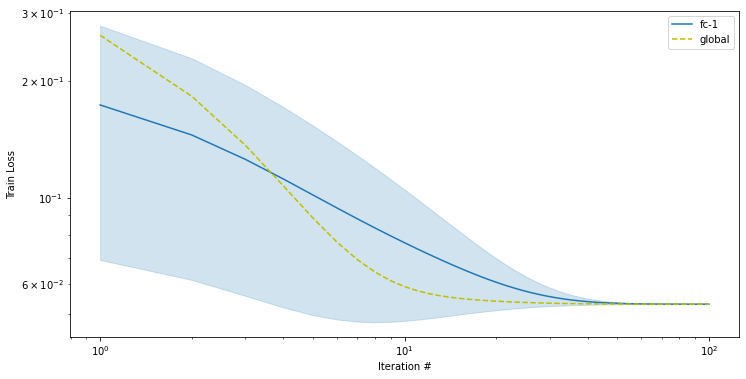

In [113]:
import itertools

# plot options
figsize = (12, 6)

fig, axes = plt.subplots(1, 1, figsize=figsize)
ax = axes
ax.set_xscale('log')
ax.set_yscale('log')
cmaps = itertools.cycle(['viridis', 'magma', 'cool'])
for topo, d1 in dfs.groupby('topo'):
    cmap = next(cmaps)
    for nb_nodes, d2 in d1.groupby('nodes'):
        # print(topo, nb_nodes, d2)
        xaxis = range(1, len(d2['loss'])+1)
        p = ax.plot(xaxis, d2['loss'], label=f'{topo}-{nb_nodes}')
        color = p[0].get_color()
        ax.fill_between(xaxis,
                        d2['loss']-d2['loss_std'],
                        d2['loss']+d2['loss_std'],
                        alpha=0.2, color=color)

ax.plot(xaxis, non_distr_losses[:len(xaxis)], 'y--', label='global')

ax.legend()
ax.set_xlabel('Iteration #')
ax.set_ylabel('Train Loss')
plt.show()